In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Problem #1

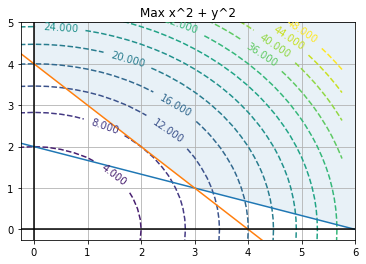

In [2]:
x_contour = np.arange(-1, 6, .25)
y_contour = np.arange(-1, 6, .25)
X, Y = np.meshgrid(x_contour, y_contour)
Z = X**2 + Y**2

x = np.linspace(-1, 6)
g1 = (6-x)/3
g2 = 4 - x

CS = plt.contour(X, Y, Z, linestyles = 'dashed', levels = range(0, 50, 4))
plt.clabel(CS, inline=1, fontsize=10, zorder = 10)

plt.plot(x, g1)
plt.plot(x, g2)
plt.fill_between(x, np.maximum(g1, g2), 50*[10], where = x>=0, alpha = .1)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim(xmin = -.25, xmax = 6)
plt.ylim(ymin = -.25, ymax = 5)
plt.grid()
plt.title('Max x^2 + y^2')

The lowest valued contour that appears to intersect with the feasible region is (2, 2), which produces a score of 8. 

## Problem 2 

$\max_{x} {V(x) : 0\leq x\leq .5}\\
V(x) = x(1-2x)^2\\
V(x) = x(1 -4x +4x^2)\\
V(x) = x - 4x^2 + 4x^3\\
\frac{dV}{dx} = 1 - 8x + 12x^2\\
0 = 1 - 8x + 12x^2\\
0 = (1 - 6x)( 1-2x)\\
x = 1/6\quad or\quad x = 1/2\\
V(1/6) = 0.074\quad or\quad V(1/2) = 0$

V(1/6) is the max

## Problem 3

I've made some minor changes to the original code to make it easier to run different files and to make it run on Python 3

In [3]:
"""
Portfolio optimization with CVXPY
See examples at http://cvxpy.org
Author: Shabbir Ahmed
"""

import pandas as pd
import numpy as np
import cvxpy

def original_code(file_name = "monthly_prices.csv"):
    # read monthly_prices.csv
    mp = pd.read_csv(file_name,index_col=0)
    mr = pd.DataFrame()

    # compute monthly returns
    for s in mp.columns:
        date = mp.index[0]
        pr0 = mp[s][date] 
        for t in range(1,len(mp.index)):
            date = mp.index[t]
            pr1 = mp[s][date]
            ret = (pr1-pr0)/pr0
            mr.set_value(date,s,ret)
            pr0 = pr1

    # get symbol names
    symbols = mr.columns

    # convert monthly return data frame to a numpy matrix
    return_data = mr.as_matrix().T

    # compute mean return
    r = np.asarray(np.mean(return_data, axis=1))

    # covariance
    C = np.asmatrix(np.cov(return_data))

    # print out expected return and std deviation
    print( "----------------------")
    for j in range(len(symbols)):
        print( '%s: Exp ret = %f, Risk = %f' %(symbols[j],r[j], C[j,j]**0.5))


    # set up optimization model
    n = len(symbols)
    x = cvxpy.Variable(n)
    req_return = 0.02
    ret = r.T*x
    risk = cvxpy.quad_form(x, C)
    prob = cvxpy.Problem(cvxpy.Minimize(risk), 
                   [cvxpy.sum(x) == 1, ret >= req_return,
                    x >= 0])

    # solve problem and write solution
    prob.solve()
    print( "----------------------")
    print( "Optimal portfolio")
    print( "----------------------")
    for s in range(len(symbols)):
        print( 'x[%s] = %f' %(symbols[s],x.value[s]))
    print( "----------------------")
    print( 'Exp ret = %f' %(ret.value))
    print( 'risk    = %f' %((risk.value)**0.5))
    print( "----------------------")


Here are the results from the provided file. No surprises here.

In [4]:
original_code()

----------------------
MSFT: Exp ret = 0.024611, Risk = 0.058040
V: Exp ret = 0.018237, Risk = 0.042807
WMT: Exp ret = 0.009066, Risk = 0.044461
----------------------
Optimal portfolio
----------------------
x[MSFT] = 0.582818
x[V] = 0.204324
x[WMT] = 0.212858
----------------------
Exp ret = 0.020000
risk    = 0.038256
----------------------


Next, we have to pull in our updated stock prices. We'll use pandas_datareader for this part.

In [5]:
import pandas_datareader.data as web
import datetime

# Set time range
start = datetime.datetime(2016, 8, 1)
end = datetime.datetime(2018, 7, 31)
symbols = ['MSFT', 'V', 'WMT']

# Import daily data
data = web.DataReader(symbols, 'iex', start, end)

# Iterate through, resampling to the end of the month and aligning the file
# format with the original file
output_df = pd.DataFrame()
for s, values in data.items():
    values.index = pd.to_datetime(values.index)
    out = values.resample('M').last()['close'].reset_index(drop = True)
    output_df[s] = out
output_df.index = output_df.index + 1

# Save the data to read it in our main code
output_df.to_csv('monthly_prices_updated.csv')

5y


Now let's rerun the original code with the new data.

In [6]:
original_code('monthly_prices_updated.csv')

----------------------
MSFT: Exp ret = 0.029315, Risk = 0.036556
V: Exp ret = 0.024180, Risk = 0.033875
WMT: Exp ret = 0.013620, Risk = 0.059141
----------------------
Optimal portfolio
----------------------
x[MSFT] = 0.395580
x[V] = 0.567177
x[WMT] = 0.037243
----------------------
Exp ret = 0.025818
risk    = 0.030919
----------------------


Due to the fact that we've been in a prolonged bull market, the original return threshold of .02 has become somewhat trivial. Two of our stocks (which happen to be the 2 less risky stocks) exceed the threshold by a significant margin on their own. The ER is higher and our risk is lower for all three stocks compared to the original dataset. This results in an optimized risk value that actually has a much higher ER than the threshold from the original problem while still hitting a lower risk value. 

In the previous iteration, hitting the threshold required a heavy investment in Microsoft as it was the only stock with an ER above the threshold. Now our solver is free to optimize almost entirely for risk and so chooses a distribution that primarily contains Visa, our lowest risk stock, with some balancing from Microsoft.

It is a little surprising that Walmart was selected at all given that it has both the highest risk and lowest ER. However, the likely explanation here is that Walmart had a fairly low covariance with one or both of our other stocks and reducing that covariance was enough to result in some decrease in risk.